## 0. Install library


In [ ]:
# !pip install stable-baselines3[extra]  # install once: SB3 + extras for env wrappers and callbacks

## 1. Import dependencies


In [ ]:
# imports: os for paths, gymnasium for envs, PPO algorithm, DummyVecEnv to vectorize, evaluate_policy for quick eval
import os
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv  # -> vectorize environment
from stable_baselines3.common.evaluation import evaluate_policy

### Important RL tips (short):

- Start with simple envs (CartPole) to understand observation/action spaces.
- Watch renderings to debug agent behavior, but disable during heavy training.
- Track rewards and use evaluation callbacks to avoid overfitting or wasted compute.
- Small experiments (network size, timesteps) teach faster than big runs.


## 2. load environments


In [ ]:
env_name = "CartPole-v1"
# render_mode='human' shows the env (use only for testing/visualizing)
env = gym.make(env_name, render_mode="human")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [ ]:
# (must be run every time)  # simple random-play loop to see env dynamics
env = gym.make(env_name, render_mode="human")

episodes = 5
for episode in range(1, episodes+1):
    # gymnasium may return (obs, info) in newer API; simple cases sometimes return just obs
    state = env.reset()
    terminated = False
    truncated = False
    done = False
    score = 0

    while not done:
        env.render()
        # random action (useful to inspect action space)
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # Set 'done' for the while loop condition
        score += reward

    print('Episode:{} Score:{}'.format(episode, score))

env.close()

Episode:1 Score:27.0
Episode:2 Score:19.0
Episode:3 Score:14.0
Episode:4 Score:30.0
Episode:5 Score:34.0


In [ ]:
env.action_space  # check action space type and shape

Discrete(2)

In [ ]:
# 0-push cart to left, 1-push cart to the right
env.action_space.sample()  # -> example random action

np.int64(1)

In [ ]:
env.observation_space  # inspect observation space shape and bounds

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

In [ ]:
# [cart position, cart velocity, pole angle, pole angular velocity]
env.observation_space.sample()  # -> example random observation

array([-4.4427724 ,  0.7804759 , -0.04131574, -0.873845  ], dtype=float32)

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

| Num | Action                 |
| --- | ---------------------- |
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
| --- | --------------------- | ------------------- | ----------------- |
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |


## 3. Train the model


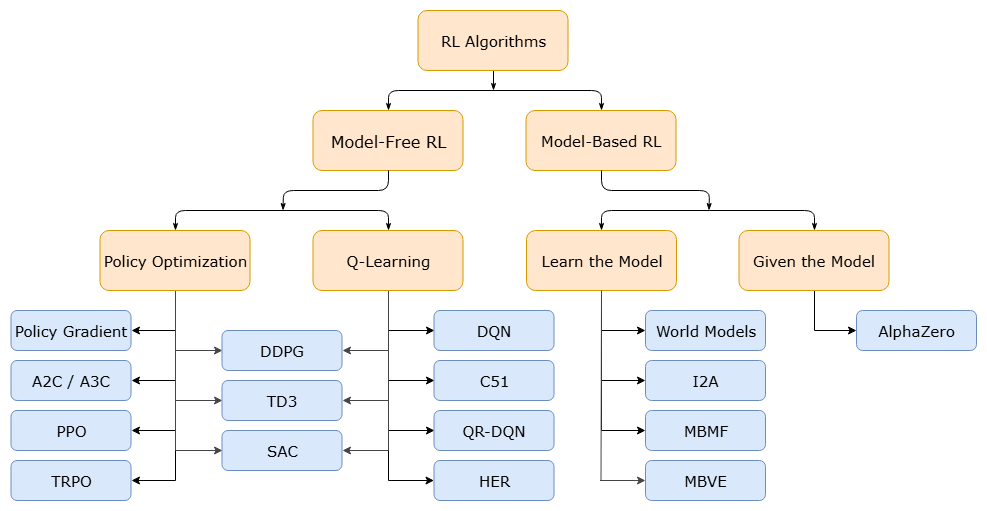


In [ ]:
log_path = os.path.join("Training", "Logs")  # path for tensorboard logs
log_path

'Training\\Logs'

In [ ]:
env = gym.make(env_name)  # create non-rendering env for training (faster)
# -> wrapping the env with the dummy vectorized env (SB3 expects vectorized envs)
env = DummyVecEnv([lambda: env])
model = PPO('MlpPolicy', env, verbose=1,
            tensorboard_log=log_path)  # PPO with MLP policy

Using cuda device


c:\Users\YOUSSEF\Desktop\Codess & Projects\.venv\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
# start training; adjust timesteps based on convergence
model.learn(total_timesteps=20000)

## 4. Save model


In [ ]:
PPO_Path = os.path.join("Training", "Saved_Models",
                        "PPO_Model_CartPole")  # save path for model

In [ ]:
model.save(PPO_Path)  # save trained policy

In [ ]:
del model  # delete to demonstrate loading

In [ ]:
# load model (provide env for continuing training/evaluation)
model = PPO.load(PPO_Path, env=env)

## 5. Evaluate the model


In [ ]:
# env = gym.make(env_name, render_mode="human")
env = gym.make(env_name)

# -> returns: avg_rewards, std (use render=True to watch)
evaluate_policy(model, env, n_eval_episodes=10, render=True)

c:\Users\YOUSSEF\Desktop\Codess & Projects\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
c:\Users\YOUSSEF\Desktop\Codess & Projects\.venv\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


(np.float64(500.0), np.float64(0.0))

## 6. Test the model


In [ ]:
# (must be run every time)  # deterministic play using the trained model to inspect behavior
env = gym.make(env_name, render_mode="human")

episodes = 5
for episode in range(1, episodes+1):
    # Unpack the result of env.reset() into observation and info
    observations, info = env.reset()  # gymnasium returns (obs, info)
    terminated = False
    truncated = False
    done = False
    score = 0

    while not done:
        env.render()
        # -> use model's predicted action (not random)
        action, _ = model.predict(observations)
        observations, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # Set 'done' for the while loop condition
        score += reward

    print('Episode:{} Score:{}'.format(episode, score))

env.close()

Episode:1 Score:500.0
Episode:2 Score:264.0
Episode:3 Score:238.0
Episode:4 Score:317.0
Episode:5 Score:500.0


In [ ]:
model.predict(observations)  # quick single-step prediction

(array(0), None)

In [ ]:
observations, info = env.reset()
action, _ = model.predict(observations)
env.step(action)  # step the env with model action

(array([-0.04126324, -0.19534215,  0.00097332,  0.27127814], dtype=float32),
 1.0,
 False,
 False,
 {})

## 6. Adding calbacks


In [ ]:
# callbacks to auto-eval and stop training
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

In [ ]:
save_path = os.path.join("Training", "Saved_Models")
env = gym.make(env_name)

stop_callback = StopTrainingOnRewardThreshold(
    reward_threshold=300, verbose=1)  # stop when target reward reached
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,
                             eval_freq=10000,
                             best_model_save_path=save_path,
                             verbose=1)  # evaluate periodically and save best model

In [ ]:
# (re)create model to use with callbacks
model = PPO("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\YOUSSEF\Desktop\Codess & Projects\.venv\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
# training with evaluation & early stopping
model.learn(total_timesteps=20000, callback=eval_callback)

## 7. Change Policy


In [ ]:
net_arch = [dict(pi=[128, 128, 128, 128], vf=[128, 128, 128, 128])]
model = PPO('MlpPolicy', env, verbose=1,
            # new policy
            policy_kwargs={'net_arch': net_arch})  # customize policy network sizes

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\YOUSSEF\Desktop\Codess & Projects\.venv\lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [ ]:
# train with the new policy architecture
model.learn(total_timesteps=20000, callback=eval_callback)

## Using an alternate algorithm


In [ ]:
# DQN is another RL algorithm (value-based), good for discrete actions
from stable_baselines3 import DQN

In [ ]:
model = DQN("MlpPolicy", env, verbose=1)  # create DQN model

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=20000)  # train DQN